# Multiclass Image Classification with Convolutional Neural Networks

## Project Overview
This project demonstrates the implementation of a Convolutional Neural Network (CNN) for classifying animal images across multiple classes. Using PyTorch to build, train, and evaluate our model on a dataset containing various animal categories.

### Key Components
- **Data Preparation**: Loading and preprocessing of the animal image dataset
- **Data Normalization**: Computing and applying dataset-specific mean and standard deviation
- **Model Design**: Implementation of convolutional neural networks with different architectures
- **Training**: Using triplet margin loss combined with cross-entropy loss 
- **Evaluation**: Measuring model performance with accuracy, F1 score, and confusion matrices
- **Visualization**: Learning curves, predictions, and model structure

In [1]:
import os
import sys
import shutil
from collections import Counter
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn.functional as F
import random
import torch
import torch.nn as nn
import torch.optim as optim


from pytorch_metric_learning import losses, miners
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, precision_recall_fscore_support
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.model_selection import train_test_split
from torchinfo import summary
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

torch.backends.cudnn.deterministic = True

## Data Preparation and Analysis

### Dataset Overview
I're using the Animal Image Dataset containing 90 different animal classes. For this project, I'll focus on the first 10 classes to build a multiclass classifier.

### Data Processing Pipeline
1. **Loading Images**: Using torchvision's ImageFolder to load structured image data
2. **Image Transformations**:
   - Convert to RGB format for consistency
   - Resize images to 224×224 pixels (standard for many CNN architectures)
   - Convert to PyTorch tensors
   - Apply data augmentation techniques (horizontal flips, rotations, color jitter)
   - Normalize using dataset mean and standard deviation

### Data Augmentation Benefits
- Increases effective training set size
- Improves model generalization by introducing variations
- Reduces overfitting by creating diversity in the training examples

### Normalization Importance
Computing and applying dataset-specific mean and standard deviation ensures:
- Faster convergence during training
- Better numerical stability
- More consistent gradient flow throughout the network

In [2]:
# Download latest version
dataset_path = kagglehub.dataset_download("iamsouravbanerjee/animal-image-dataset-90-different-animals")

print("Path to dataset files:", dataset_path)

new_path = "data"

def move_files(source_path, destination_path):
    for item in os.listdir(source_path):
        s = os.path.join(source_path, item)
        d = os.path.join(destination_path, item)
        shutil.move(s, d)
        print(f"Moved file: {s} to {d}")


move_files(dataset_path, new_path)

Path to dataset files: C:\Users\LENOVO\.cache\kagglehub\datasets\iamsouravbanerjee\animal-image-dataset-90-different-animals\versions\5


In [3]:
data_classes_path = os.path.join(new_path, "animals/animals")
classes = os.listdir(data_classes_path)
classes[:10]

['antelope',
 'badger',
 'bat',
 'bear',
 'bee',
 'beetle',
 'bison',
 'boar',
 'butterfly',
 'cat']

In [4]:
def split_data_into_train_test(source_dir, target_base_dir, test_ratio=0.2, random_state=42):
    """
    Splits data from source_dir into train and test folders while preserving class structure.
    """
    # Create target directories
    train_dir = os.path.join(target_base_dir, 'train')
    test_dir = os.path.join(target_base_dir, 'test')
    
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    
    # Set random seed for reproducibility
    random.seed(random_state)
    np.random.seed(random_state)
    
    # Get class folders
    class_folders = [f for f in os.listdir(source_dir) 
                    if os.path.isdir(os.path.join(source_dir, f))]
    
    print(f"Found {len(class_folders)} classes: {class_folders}")
    
    # Process each class
    for class_name in class_folders:
        print(f"Processing class: {class_name}")
        
        # Create corresponding class folders in train and test directories
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
        
        # Get all files for this class
        class_path = os.path.join(source_dir, class_name)
        files = [f for f in os.listdir(class_path) 
                if os.path.isfile(os.path.join(class_path, f))]
        
        # Split the files
        train_files, test_files = train_test_split(
            files, test_size=test_ratio, random_state=random_state
        )
        
        # Copy files to train directory
        for file in train_files:
            src = os.path.join(class_path, file)
            dst = os.path.join(train_dir, class_name, file)
            shutil.copy2(src, dst)
        
        # Copy files to test directory
        for file in test_files:
            src = os.path.join(class_path, file)
            dst = os.path.join(test_dir, class_name, file)
            shutil.copy2(src, dst)
        
        print(f"  - Split {len(files)} files into {len(train_files)} train and {len(test_files)} test")

# Example usage
source_directory = "data/animals/animals"  
target_directory = "data"   

split_data_into_train_test(source_directory, target_directory)

Check the GPU device if it is available. Store the device name in the variable `device`.

In [5]:
# Check if CUDA is available before using it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Device: {device}")

Device: cuda


In [6]:
class ConvertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img
    
transform = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]
)

In [7]:
data_dir = os.path.join("data", "animals", "animals")
train_dir = os.path.join("data", "train")
test_dir = os.path.join("data", "test")

dataset = datasets.ImageFolder(root=train_dir, transform=transform)

# Use the first 10 classes
selected_classes = dataset.classes[:10]

# Create subset with only samples from those 10 classes
selected_indices = [idx for idx, (_, label) in enumerate(dataset.samples) if label < 10]
subset_dataset = Subset(dataset, selected_indices)

# Create DataLoader
batch_size = 32
dataset_loader = DataLoader(subset_dataset, batch_size=batch_size)

all_labels = []
for idx in range(len(subset_dataset)):
    _, label = subset_dataset[idx]
    all_labels.append(label)

# Count unique labels
unique_labels = set(all_labels)
print(f"Number of unique classes in subset: {len(unique_labels)}")
print(f"Unique class indices: {unique_labels}")

# Get class names for these indices
class_names = [dataset.classes[label] for label in unique_labels]
print(f"Class names in subset: {class_names}")

print()
print("Tensor shape for one image:")
print(dataset[0][0].shape)

Number of unique classes in subset: 10
Unique class indices: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Class names in subset: ['antelope', 'badger', 'bat', 'bear', 'bee', 'beetle', 'bison', 'boar', 'butterfly', 'cat']

Tensor shape for one image:
torch.Size([3, 224, 224])


In [8]:
def get_mean_std(loader):
    """Computes the mean and standard deviation of image data.

    Input: a `DataLoader` producing tensors of shape [batch_size, channels, pixels_x, pixels_y]
    Output: the mean of each channel as a tensor, the standard deviation of each channel as a tensor
            formatted as a tuple (means[channels], std[channels])"""

    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(loader, desc="Computing mean and std", leave=False):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2) ** 0.5

    return mean, std

### Check mean, srd before normalization

In [9]:
mean, std = get_mean_std(dataset_loader)

print(f"Mean: {mean}")
print(f"Standard deviation: {std}")

Computing mean and std:   0%|          | 0/15 [00:00<?, ?it/s]

Mean: tensor([0.5272, 0.5025, 0.4178])
Standard deviation: tensor([0.2872, 0.2819, 0.2980])


### Normalization

In [10]:
transform_norm = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.Normalize(mean=mean, std=std)
    ]
)

In [11]:
norm_dataset = datasets.ImageFolder(root=train_dir, transform=transform_norm)

# Use the first 10 classes
selected_classes = norm_dataset.classes[:10]

# Create subset with only samples from those 10 classes
selected_indices = [idx for idx, (_, label) in enumerate(norm_dataset.samples) if label < 10]
subset_norm_dataset = Subset(norm_dataset, selected_indices)

# Create DataLoader
batch_size = 32
norm_loader = DataLoader(subset_norm_dataset, batch_size=batch_size)

all_labels = []
for idx in range(len(subset_norm_dataset)):
    _, label = subset_norm_dataset[idx]
    all_labels.append(label)

# Count unique labels
unique_labels = set(all_labels)
print(f"Number of unique classes in subset: {len(unique_labels)}")
print(f"Unique class indices: {unique_labels}")

# Get class names for these indices
class_names = [norm_dataset.classes[label] for label in unique_labels]
print(f"Class names in subset: {class_names}")

print()
print("Tensor shape for one image:")
print(norm_dataset[0][0].shape)

Number of unique classes in subset: 10
Unique class indices: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Class names in subset: ['antelope', 'badger', 'bat', 'bear', 'bee', 'beetle', 'bison', 'boar', 'butterfly', 'cat']

Tensor shape for one image:
torch.Size([3, 224, 224])


### Mean, Std after Normalization

In [12]:
norm_mean, norm_std = get_mean_std(norm_loader)

print(f"Mean: {norm_mean}")
print(f"Standard deviation: {norm_std}")

Computing mean and std:   0%|          | 0/15 [00:00<?, ?it/s]

Mean: tensor([-0.0918, -0.0878, -0.0658])
Standard deviation: tensor([1.0336, 1.0321, 1.0018])


### Train and validation splitting

In [13]:
g = torch.Generator()
g.manual_seed(42)

train_dataset, val_dataset = random_split(subset_norm_dataset, [0.8, 0.2], generator=g)

length_train = len(train_dataset)
length_val = len(val_dataset)
length_dataset = len(subset_norm_dataset)
percent_train = np.round(100 * length_train / length_dataset, 2)
percent_val = np.round(100 * length_val / length_dataset, 2)

print(f"Train data is {percent_train}% of full data")
print(f"Validation data is {percent_val}% of full data")

Train data is 80.0% of full data
Validation data is 20.0% of full data


In [14]:
def class_counts(dataset):
    # Count labels directly from dataset
    labels = [dataset[i][1] for i in range(len(dataset))]
    counter = Counter(labels)
    
    # Get class names from original dataset
    class_names = sorted(norm_dataset.classes)
    
    # Create series with class names as index and sort alphabetically
    series = pd.Series({class_names[label]: count for label, count in counter.items()})
    return series.sort_index()

train_class_distributions = class_counts(train_dataset)

train_class_distributions

antelope     36
badger       42
bat          38
bear         42
bee          39
beetle       38
bison        41
boar         35
butterfly    38
cat          35
dtype: int64

### Class Distribution in Both Training/Validation Sets

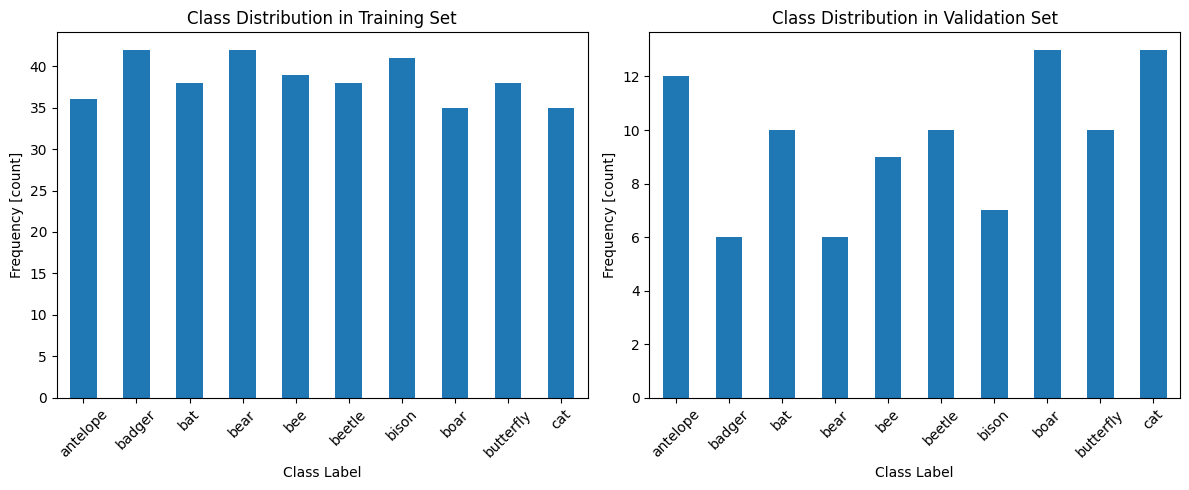

In [15]:
validation_class_distributions = class_counts(val_dataset)

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot training distribution
train_class_distributions.plot(kind='bar', ax=ax1)
ax1.set_xlabel("Class Label")
ax1.set_ylabel("Frequency [count]")
ax1.set_title("Class Distribution in Training Set")
ax1.tick_params(axis='x', rotation=45)

# Plot validation distribution
validation_class_distributions.plot(kind='bar', ax=ax2)
ax2.set_xlabel("Class Label") 
ax2.set_ylabel("Frequency [count]")
ax2.set_title("Class Distribution in Validation Set")
ax2.tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

### Data loaders for the train and validation sets

In [16]:
g = torch.Generator()
g.manual_seed(42)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=g)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, generator=g)

single_batch = next(iter(train_loader))[0]
print(f"Shape of one batch: {single_batch.shape}")

Shape of one batch: torch.Size([32, 3, 224, 224])


## CNN Model Architecture

### Understanding Our Model Design

I'll implement two different CNN architectures to compare their performance:

#### Architecture 1: Complex CNN with Dual Convolutions
This architecture uses blocks containing two convolutional layers followed by batch normalization, ReLU activation, and max pooling. This design follows the VGG-style approach where we progressively increase the number of filters while reducing spatial dimensions.

Each convolutional block contains:
- Two Conv2D layers with the same number of filters
- BatchNorm2D after each convolution for training stability
- ReLU activation to introduce non-linearity
- MaxPool2D to reduce spatial dimensions by half

The fully connected layers include dropout for regularization to prevent overfitting.

#### Architecture 2: Simpler CNN with Single Convolutions
This architecture uses a simpler approach with single convolutional layers followed by ReLU and max pooling. This design may be more suitable for smaller datasets where complex models might overfit.

Each layer sequence contains:
- One Conv2D layer
- ReLU activation
- MaxPool2D

In [17]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)


## architecture 1
# def create_conv_block(in_channels, out_channels, kernel_size=3):
#     return torch.nn.Sequential(
#         torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding="same"),
#         torch.nn.BatchNorm2d(num_features=out_channels),
#         torch.nn.ReLU(),
#         torch.nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding="same"), 
#         torch.nn.BatchNorm2d(num_features=out_channels),
#         torch.nn.ReLU(),
#         torch.nn.MaxPool2d(kernel_size=2)
#     )

# model = torch.nn.Sequential(
#     create_conv_block(in_channels=3, out_channels=8, kernel_size=(3, 3)),
#     create_conv_block(in_channels=8, out_channels=16, kernel_size=(3, 3)),
#     create_conv_block(in_channels=16, out_channels=32, kernel_size=(3, 3)),
#     # create_conv_block(in_channels=32, out_channels=64, kernel_size=(3, 3)),
#     # create_conv_block(in_channels=64, out_channels=64, kernel_size=(3, 3)),
#     torch.nn.Flatten(),
#     torch.nn.Sequential(
#         torch.nn.Dropout(0.5),
#         torch.nn.Linear(in_features=25088, out_features=512),
#         torch.nn.ReLU(),
#     ),
#     torch.nn.Sequential(
#         torch.nn.Dropout(),
#         torch.nn.Linear(in_features=512, out_features=len(selected_classes)),
#     )
# )


## architecture 2
model = torch.nn.Sequential()

conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1)
max_pool1 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2)
model.append(conv1)
model.append(torch.nn.ReLU())
model.append(max_pool1)

conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1)
max_pool2 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2)
model.append(conv2)
model.append(torch.nn.ReLU())
model.append(max_pool2)

conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1)
max_pool3 = torch.nn.MaxPool2d(2)
model.append(conv3)
model.append(torch.nn.ReLU())
model.append(max_pool3)

model.append(torch.nn.Flatten())
model.append(torch.nn.Dropout())

linear1 = torch.nn.Linear(in_features=50176, out_features=500)
model.append(linear1)
model.append(torch.nn.ReLU())
model.append(torch.nn.Dropout())

output_layer = torch.nn.Linear(500, 10)
model.append(output_layer)


model_stats = summary(model, input_size=(batch_size, 3, 224, 224))
model_stats


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 10]                  --
├─Conv2d: 1-1                            [32, 16, 224, 224]        448
├─ReLU: 1-2                              [32, 16, 224, 224]        --
├─MaxPool2d: 1-3                         [32, 16, 112, 112]        --
├─Conv2d: 1-4                            [32, 32, 112, 112]        4,640
├─ReLU: 1-5                              [32, 32, 112, 112]        --
├─MaxPool2d: 1-6                         [32, 32, 56, 56]          --
├─Conv2d: 1-7                            [32, 64, 56, 56]          18,496
├─ReLU: 1-8                              [32, 64, 56, 56]          --
├─MaxPool2d: 1-9                         [32, 64, 28, 28]          --
├─Flatten: 1-10                          [32, 50176]               --
├─Dropout: 1-11                          [32, 50176]               --
├─Linear: 1-12                           [32, 500]                 25,088,500

In [18]:
# loss function
loss_fn = nn.CrossEntropyLoss()
metric_loss = losses.TripletMarginLoss(margin=0.2)

# optimizer and learning rate scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                     patience=5, factor=0.5, 
                                                     verbose=True)
model.to(device)

C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=50176, out_features=500, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=500, out_features=10, bias=True)
)

## Training Methodology

### Loss Functions
Our training approach combines two complementary loss functions:

1. **Cross-Entropy Loss**: The standard loss function for classification tasks, which measures the difference between predicted class probabilities and actual class labels.

2. **Triplet Margin Loss**: A metric learning approach that helps the model learn better feature representations by ensuring that:
   - Samples from the same class are pulled closer together in the feature space
   - Samples from different classes are pushed further apart
   
The MultiSimilarityMiner helps identify hard pairs (challenging examples) for the triplet loss, making training more efficient.

### Optimizer
I use Adam optimizer with weight decay (L2 regularization) to:
- Adapt learning rates for each parameter
- Add regularization to prevent overfitting

### Training Loop
For each epoch:
1. Train the model on training data
2. Evaluate on validation data
3. Track losses and accuracies for both sets
4. Update model parameters based on the combined loss

### Monitoring Progress
I track both training and validation metrics to detect potential overfitting (when validation performance degrades while training performance continues to improve).

In [19]:
def train_epoch(model, optimizer, loss_fn, data_loader, device):

    training_loss = 0.0
    correct = 0
    total = 0

    # The train method simply sets the model in training mode
    model.train()

    # Iterate over all batches in the training set to complete one epoch
    for inputs, targets in tqdm(data_loader, desc="Training", leave=False):
        # Sets the gradients to zero
        optimizer.zero_grad()

        # Unpack images (X) and labels (y) from the batch and add those tensors to the specified device.
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Make a forward pass through the network and obtain the logits to calculate the loss.
        output = model(inputs)
        # loss = loss_fn(output, targets)
        
        hard_pairs = miners.MultiSimilarityMiner()(output, targets)
        metric_l = metric_loss(output, targets, hard_pairs)

        # embeddings = model.projection(output.view(output.size(0), -1))
        # class_logits = model.classify(embeddings)
        class_l = loss_fn(output, targets)

        loss = metric_l + class_l

        # After calculating our loss, calculate the numerical value of the derivative of our loss function with respect to all the trainable model weights.
        # Once have the gradients calculated, let the optimizer take a "step", in other words, update or adjust the model weights.
        loss.backward()
        optimizer.step()

        # Increment the training loss for the current batch
        training_loss += loss.data.item() * inputs.size(0)
        _, predicted = torch.max(output, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    return training_loss / len(data_loader.dataset), correct / total

In [20]:
def score(model, data_loader, loss_fn, device=device):
    # Initialize tracking variables for loss and correct predictions
    total_loss = 0
    total_correct = 0

    # Set model to evaluation mode
    model.eval()

    # Disable gradient calculations for inference
    with torch.no_grad():
        # Process each batch
        for inputs, targets in tqdm(data_loader, desc="Scoring", leave=False):
            inputs = inputs.to(device)
            output = model(inputs)

            # Calculate loss
            targets = targets.to(device)
            loss = loss_fn(output, targets)
            total_loss += loss.data.item() * inputs.size(0)

            # Track correct predictions
            correct = torch.eq(torch.argmax(output, dim=1), targets)
            total_correct += torch.sum(correct).item()

    return total_loss / len(data_loader.dataset), total_correct / len(data_loader.dataset)

In [21]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

def train(model, optimizer, loss_fn, train_loader, val_loader, epochs, device=device):

    for epoch in range(1, epochs + 1):
        # Run train_epoch once, and capture the training loss and accuracy.
        training_loss, training_accuracy = train_epoch(model, optimizer, loss_fn, train_loader, device)

        train_losses.append(training_loss)
        train_accuracies.append(training_accuracy)

        # Score the model on the validation data.
        validation_loss, validation_accuracy = score(model, val_loader, loss_fn, device)

        val_losses.append(validation_loss)
        val_accuracies.append(validation_accuracy)


        # A learning rate scheduler adjusts the learning rate during training, typically reducing it when
        # validation loss plateaus to help fine-tune the model. 
        # scheduler.step(avg_val_loss)

        print(f"Epoch: {epoch}, Training Loss: {training_loss:.2f}, Train Acc: {training_accuracy:.4f}")
        print(f"Validation Loss: {validation_loss:.2f}, Validation Accuracy: {validation_accuracy:.2f}")       


def predict(model, data_loader, device=device):
    # Initialize empty tensor for storing predictions
    all_probs = torch.tensor([]).to(device)

    # Set model to evaluation mode for inference
    model.eval()

    # Disable gradient calculations for faster inference
    with torch.no_grad():

        # Process each batch through the model
        for inputs, targets in tqdm(data_loader, desc="Predicting", leave=False):
            inputs = inputs.to(device)
            output = model(inputs)

            # Convert logits to probabilities using softmax
            # and concatenate with previous predictions
            probs = F.softmax(output, dim=1)
            all_probs = torch.cat((all_probs, probs), dim=0)

    return all_probs

In [22]:
model = model.to(device)
num_epochs = 100

train(model, optimizer, loss_fn, train_loader, val_loader, epochs=num_epochs, device=device)

Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1, Training Loss: 2.78, Train Acc: 0.1146
Validation Loss: 2.29, Validation Accuracy: 0.10


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 2, Training Loss: 2.52, Train Acc: 0.0990
Validation Loss: 2.28, Validation Accuracy: 0.10


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 3, Training Loss: 2.46, Train Acc: 0.1562
Validation Loss: 2.27, Validation Accuracy: 0.19


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 4, Training Loss: 2.42, Train Acc: 0.2318
Validation Loss: 2.21, Validation Accuracy: 0.21


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 5, Training Loss: 2.31, Train Acc: 0.3073
Validation Loss: 2.10, Validation Accuracy: 0.27


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 6, Training Loss: 2.16, Train Acc: 0.3776
Validation Loss: 1.93, Validation Accuracy: 0.34


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 7, Training Loss: 2.00, Train Acc: 0.4193
Validation Loss: 1.97, Validation Accuracy: 0.30


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 8, Training Loss: 1.87, Train Acc: 0.4974
Validation Loss: 2.19, Validation Accuracy: 0.25


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 9, Training Loss: 1.84, Train Acc: 0.4740
Validation Loss: 1.90, Validation Accuracy: 0.32


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 10, Training Loss: 1.66, Train Acc: 0.5286
Validation Loss: 1.97, Validation Accuracy: 0.34


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 11, Training Loss: 1.55, Train Acc: 0.5990
Validation Loss: 1.93, Validation Accuracy: 0.34


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 12, Training Loss: 1.48, Train Acc: 0.5807
Validation Loss: 2.11, Validation Accuracy: 0.35


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 13, Training Loss: 1.47, Train Acc: 0.5807
Validation Loss: 2.08, Validation Accuracy: 0.34


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 14, Training Loss: 1.25, Train Acc: 0.6875
Validation Loss: 2.04, Validation Accuracy: 0.36


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 15, Training Loss: 1.31, Train Acc: 0.6536
Validation Loss: 2.11, Validation Accuracy: 0.39


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 16, Training Loss: 1.20, Train Acc: 0.6693
Validation Loss: 2.03, Validation Accuracy: 0.41


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 17, Training Loss: 1.14, Train Acc: 0.7135
Validation Loss: 2.10, Validation Accuracy: 0.40


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 18, Training Loss: 1.03, Train Acc: 0.7604
Validation Loss: 2.04, Validation Accuracy: 0.44


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 19, Training Loss: 1.02, Train Acc: 0.7604
Validation Loss: 2.18, Validation Accuracy: 0.38


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 20, Training Loss: 0.96, Train Acc: 0.7552
Validation Loss: 2.14, Validation Accuracy: 0.42


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 21, Training Loss: 0.86, Train Acc: 0.8047
Validation Loss: 2.33, Validation Accuracy: 0.40


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 22, Training Loss: 0.77, Train Acc: 0.8255
Validation Loss: 2.38, Validation Accuracy: 0.46


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 23, Training Loss: 0.74, Train Acc: 0.8255
Validation Loss: 2.51, Validation Accuracy: 0.36


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 24, Training Loss: 0.75, Train Acc: 0.8333
Validation Loss: 2.22, Validation Accuracy: 0.41


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 25, Training Loss: 0.79, Train Acc: 0.8333
Validation Loss: 2.40, Validation Accuracy: 0.44


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 26, Training Loss: 0.66, Train Acc: 0.8724
Validation Loss: 2.44, Validation Accuracy: 0.42


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 27, Training Loss: 0.56, Train Acc: 0.8828
Validation Loss: 2.62, Validation Accuracy: 0.46


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 28, Training Loss: 0.66, Train Acc: 0.8698
Validation Loss: 2.60, Validation Accuracy: 0.41


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 29, Training Loss: 0.64, Train Acc: 0.8724
Validation Loss: 2.36, Validation Accuracy: 0.49


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 30, Training Loss: 0.64, Train Acc: 0.8620
Validation Loss: 2.49, Validation Accuracy: 0.44


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 31, Training Loss: 0.49, Train Acc: 0.9141
Validation Loss: 2.80, Validation Accuracy: 0.43


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 32, Training Loss: 0.44, Train Acc: 0.9375
Validation Loss: 2.81, Validation Accuracy: 0.46


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 33, Training Loss: 0.49, Train Acc: 0.9219
Validation Loss: 2.93, Validation Accuracy: 0.42


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 34, Training Loss: 0.45, Train Acc: 0.9323
Validation Loss: 2.97, Validation Accuracy: 0.46


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 35, Training Loss: 0.43, Train Acc: 0.9219
Validation Loss: 2.47, Validation Accuracy: 0.50


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 36, Training Loss: 0.40, Train Acc: 0.9427
Validation Loss: 2.84, Validation Accuracy: 0.47


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 37, Training Loss: 0.51, Train Acc: 0.8958
Validation Loss: 2.59, Validation Accuracy: 0.48


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 38, Training Loss: 0.38, Train Acc: 0.9453
Validation Loss: 2.52, Validation Accuracy: 0.46


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 39, Training Loss: 0.38, Train Acc: 0.9297
Validation Loss: 2.66, Validation Accuracy: 0.44


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 40, Training Loss: 0.35, Train Acc: 0.9557
Validation Loss: 2.83, Validation Accuracy: 0.45


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 41, Training Loss: 0.36, Train Acc: 0.9479
Validation Loss: 2.81, Validation Accuracy: 0.49


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 42, Training Loss: 0.34, Train Acc: 0.9609
Validation Loss: 3.24, Validation Accuracy: 0.47


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 43, Training Loss: 0.37, Train Acc: 0.9427
Validation Loss: 3.35, Validation Accuracy: 0.44


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 44, Training Loss: 0.41, Train Acc: 0.9505
Validation Loss: 3.17, Validation Accuracy: 0.48


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 45, Training Loss: 0.33, Train Acc: 0.9557
Validation Loss: 3.05, Validation Accuracy: 0.49


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 46, Training Loss: 0.31, Train Acc: 0.9714
Validation Loss: 2.99, Validation Accuracy: 0.45


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 47, Training Loss: 0.34, Train Acc: 0.9453
Validation Loss: 3.09, Validation Accuracy: 0.44


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 48, Training Loss: 0.33, Train Acc: 0.9583
Validation Loss: 2.70, Validation Accuracy: 0.47


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 49, Training Loss: 0.33, Train Acc: 0.9531
Validation Loss: 3.16, Validation Accuracy: 0.46


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 50, Training Loss: 0.33, Train Acc: 0.9635
Validation Loss: 2.82, Validation Accuracy: 0.49


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 51, Training Loss: 0.39, Train Acc: 0.9531
Validation Loss: 2.86, Validation Accuracy: 0.44


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 52, Training Loss: 0.33, Train Acc: 0.9557
Validation Loss: 3.13, Validation Accuracy: 0.47


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 53, Training Loss: 0.29, Train Acc: 0.9661
Validation Loss: 3.46, Validation Accuracy: 0.43


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 54, Training Loss: 0.33, Train Acc: 0.9583
Validation Loss: 3.16, Validation Accuracy: 0.49


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 55, Training Loss: 0.35, Train Acc: 0.9557
Validation Loss: 3.83, Validation Accuracy: 0.45


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 56, Training Loss: 0.38, Train Acc: 0.9401
Validation Loss: 3.29, Validation Accuracy: 0.48


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 57, Training Loss: 0.35, Train Acc: 0.9531
Validation Loss: 3.61, Validation Accuracy: 0.44


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 58, Training Loss: 0.41, Train Acc: 0.9401
Validation Loss: 3.32, Validation Accuracy: 0.47


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 59, Training Loss: 0.32, Train Acc: 0.9661
Validation Loss: 3.74, Validation Accuracy: 0.48


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 60, Training Loss: 0.29, Train Acc: 0.9635
Validation Loss: 2.85, Validation Accuracy: 0.46


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 61, Training Loss: 0.32, Train Acc: 0.9714
Validation Loss: 3.09, Validation Accuracy: 0.47


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 62, Training Loss: 0.31, Train Acc: 0.9531
Validation Loss: 3.21, Validation Accuracy: 0.43


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 63, Training Loss: 0.29, Train Acc: 0.9635
Validation Loss: 3.34, Validation Accuracy: 0.42


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 64, Training Loss: 0.29, Train Acc: 0.9583
Validation Loss: 3.17, Validation Accuracy: 0.45


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 65, Training Loss: 0.24, Train Acc: 0.9844
Validation Loss: 3.87, Validation Accuracy: 0.43


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 66, Training Loss: 0.28, Train Acc: 0.9714
Validation Loss: 3.41, Validation Accuracy: 0.48


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 67, Training Loss: 0.28, Train Acc: 0.9740
Validation Loss: 2.71, Validation Accuracy: 0.47


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 68, Training Loss: 0.27, Train Acc: 0.9818
Validation Loss: 2.87, Validation Accuracy: 0.47


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 69, Training Loss: 0.27, Train Acc: 0.9870
Validation Loss: 3.42, Validation Accuracy: 0.45


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 70, Training Loss: 0.30, Train Acc: 0.9714
Validation Loss: 3.28, Validation Accuracy: 0.45


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 71, Training Loss: 0.29, Train Acc: 0.9740
Validation Loss: 3.11, Validation Accuracy: 0.46


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 72, Training Loss: 0.26, Train Acc: 0.9740
Validation Loss: 2.95, Validation Accuracy: 0.44


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 73, Training Loss: 0.28, Train Acc: 0.9740
Validation Loss: 3.10, Validation Accuracy: 0.49


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 74, Training Loss: 0.24, Train Acc: 0.9818
Validation Loss: 3.45, Validation Accuracy: 0.46


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 75, Training Loss: 0.28, Train Acc: 0.9740
Validation Loss: 3.00, Validation Accuracy: 0.52


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 76, Training Loss: 0.31, Train Acc: 0.9714
Validation Loss: 3.63, Validation Accuracy: 0.48


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 77, Training Loss: 0.32, Train Acc: 0.9714
Validation Loss: 2.91, Validation Accuracy: 0.50


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 78, Training Loss: 0.23, Train Acc: 0.9844
Validation Loss: 3.21, Validation Accuracy: 0.51


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 79, Training Loss: 0.29, Train Acc: 0.9714
Validation Loss: 3.04, Validation Accuracy: 0.51


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 80, Training Loss: 0.26, Train Acc: 0.9896
Validation Loss: 3.44, Validation Accuracy: 0.48


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 81, Training Loss: 0.26, Train Acc: 0.9740
Validation Loss: 3.04, Validation Accuracy: 0.43


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 82, Training Loss: 0.33, Train Acc: 0.9688
Validation Loss: 3.13, Validation Accuracy: 0.49


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 83, Training Loss: 0.27, Train Acc: 0.9766
Validation Loss: 3.55, Validation Accuracy: 0.48


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 84, Training Loss: 0.29, Train Acc: 0.9688
Validation Loss: 3.31, Validation Accuracy: 0.46


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 85, Training Loss: 0.24, Train Acc: 0.9818
Validation Loss: 3.04, Validation Accuracy: 0.52


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 86, Training Loss: 0.22, Train Acc: 0.9844
Validation Loss: 3.52, Validation Accuracy: 0.45


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 87, Training Loss: 0.24, Train Acc: 0.9766
Validation Loss: 3.61, Validation Accuracy: 0.49


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 88, Training Loss: 0.22, Train Acc: 0.9870
Validation Loss: 3.61, Validation Accuracy: 0.44


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 89, Training Loss: 0.28, Train Acc: 0.9844
Validation Loss: 3.50, Validation Accuracy: 0.48


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 90, Training Loss: 0.28, Train Acc: 0.9714
Validation Loss: 3.31, Validation Accuracy: 0.49


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 91, Training Loss: 0.28, Train Acc: 0.9844
Validation Loss: 3.07, Validation Accuracy: 0.49


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 92, Training Loss: 0.20, Train Acc: 0.9896
Validation Loss: 3.32, Validation Accuracy: 0.49


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 93, Training Loss: 0.20, Train Acc: 0.9948
Validation Loss: 3.41, Validation Accuracy: 0.49


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 94, Training Loss: 0.23, Train Acc: 0.9896
Validation Loss: 3.63, Validation Accuracy: 0.45


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 95, Training Loss: 0.29, Train Acc: 0.9740
Validation Loss: 3.27, Validation Accuracy: 0.40


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 96, Training Loss: 0.23, Train Acc: 0.9870
Validation Loss: 3.15, Validation Accuracy: 0.48


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 97, Training Loss: 0.26, Train Acc: 0.9818
Validation Loss: 3.70, Validation Accuracy: 0.52


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 98, Training Loss: 0.26, Train Acc: 0.9818
Validation Loss: 3.60, Validation Accuracy: 0.47


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 99, Training Loss: 0.30, Train Acc: 0.9792
Validation Loss: 3.51, Validation Accuracy: 0.50


Training:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 100, Training Loss: 0.20, Train Acc: 0.9948
Validation Loss: 3.21, Validation Accuracy: 0.53


## Model Evaluation

### Evaluation Metrics
I use multiple metrics to get a comprehensive understanding of model performance:

1. **Accuracy**: The proportion of correctly classified images
   - Simple to understand but can be misleading with imbalanced classes

2. **F1 Score**: The harmonic mean of precision and recall
   - Balances precision (how many selected items are relevant) and recall (how many relevant items are selected)
   - Better for imbalanced datasets

3. **Confusion Matrix**: A table showing predicted vs. actual class assignments
   - Helps identify which classes the model confuses with each other
   - Highlights potential patterns in misclassifications

### Analyzing Learning Curves
Learning curves plot training and validation metrics over time and help us:
- Determine if the model is overfitting (validation loss increases while training loss decreases)
- Identify if more training epochs would be beneficial
- Decide when to stop training (early stopping)

### Visualization of Predictions
Visualizing correctly and incorrectly classified images provides:
- Intuition about what features the model is learning
- Insight into challenging cases
- Ideas for potential model or data improvements

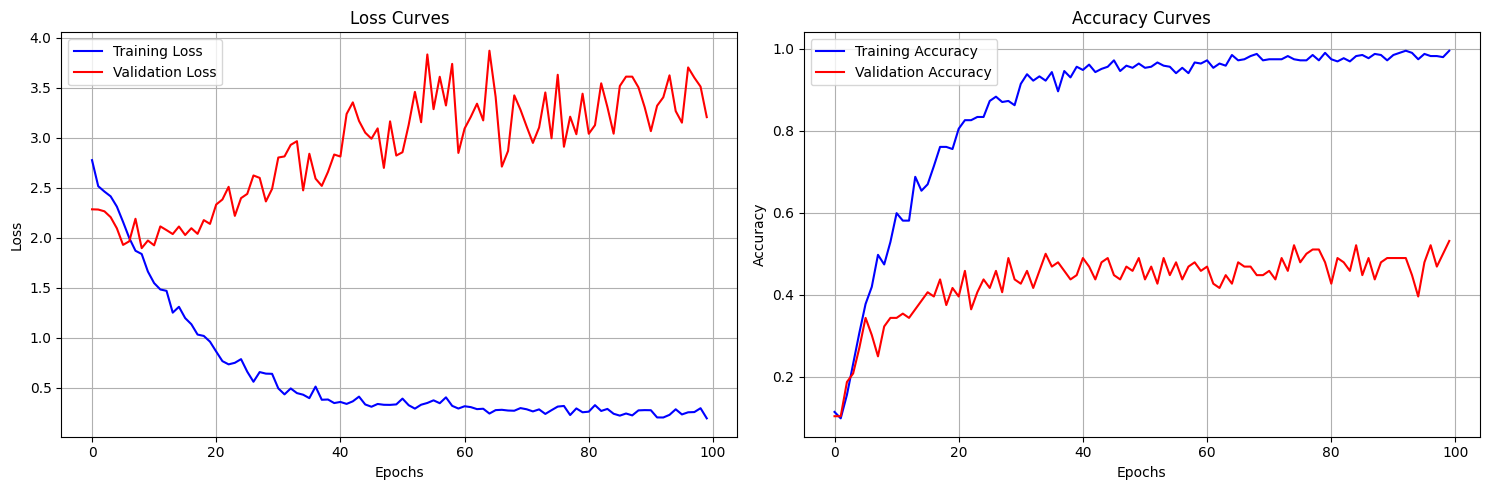

In [30]:
# Create a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot the loss curves
ax1.plot(train_losses, 'b-', label='Training Loss')
ax1.plot(val_losses, 'r-', label='Validation Loss')
ax1.set_title('Loss Curves')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot the accuracy curves
ax2.plot(train_accuracies, 'b-', label='Training Accuracy')
ax2.plot(val_accuracies, 'r-', label='Validation Accuracy')
ax2.set_title('Accuracy Curves')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [31]:
probabilities_val = predict(model, val_loader, device)
predictions_val = torch.argmax(probabilities_val, dim=1)

print("Number of predictions:", predictions_val.shape)
print(predictions_val[:10])

Predicting:   0%|          | 0/3 [00:00<?, ?it/s]

Number of predictions: torch.Size([96])
tensor([0, 4, 5, 9, 8, 2, 9, 8, 2, 8], device='cuda:0')


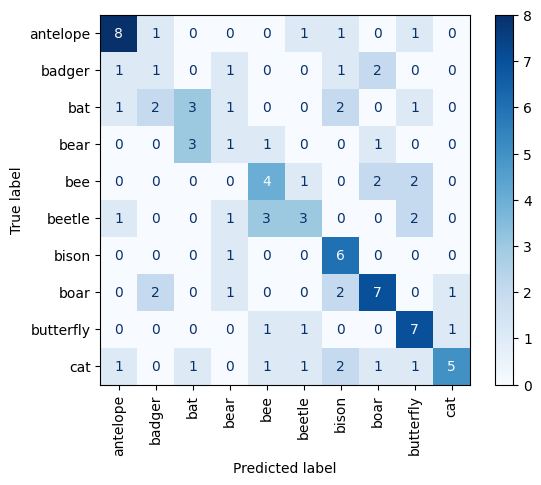

In [32]:
targets_val = torch.cat([labels for _, labels in val_loader]).to(device)

cm = confusion_matrix(targets_val.cpu(), predictions_val.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=selected_classes)

disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical");

## Final Check with Test Data

In [34]:
dataset_test = datasets.ImageFolder(root=test_dir, transform=transform_norm)
dataset_test_for_display = datasets.ImageFolder(root=test_dir, transform=transform)

# Use the first 10 classes as the same with train data
selected_classes_test = dataset_test.classes[:10]

# Create subset with only samples from those 10 classes
selected_indices_test = [idx for idx, (_, label) in enumerate(dataset_test.samples) if label < 10]
subset_dataset_test = Subset(dataset_test, selected_indices_test)
subset_dataset_test_for_display = Subset(dataset_test_for_display, selected_indices_test)

# Create DataLoader
batch_size = 32
test_loader = DataLoader(subset_dataset_test, batch_size=batch_size, shuffle=False)
test_loader_for_display = DataLoader(subset_dataset_test_for_display, batch_size=batch_size, shuffle=False)

In [35]:
# Predict the probabilities for each test image
test_probabilities = predict(model, test_loader, device)

# Get the index associated with the largest probability for each test image
test_predictions = torch.argmax(test_probabilities, dim=1).to("cpu")

test_classes = [classes[i] for i in test_predictions]

print("Number of class predictions:", len(test_classes))

Predicting:   0%|          | 0/4 [00:00<?, ?it/s]

Number of class predictions: 120


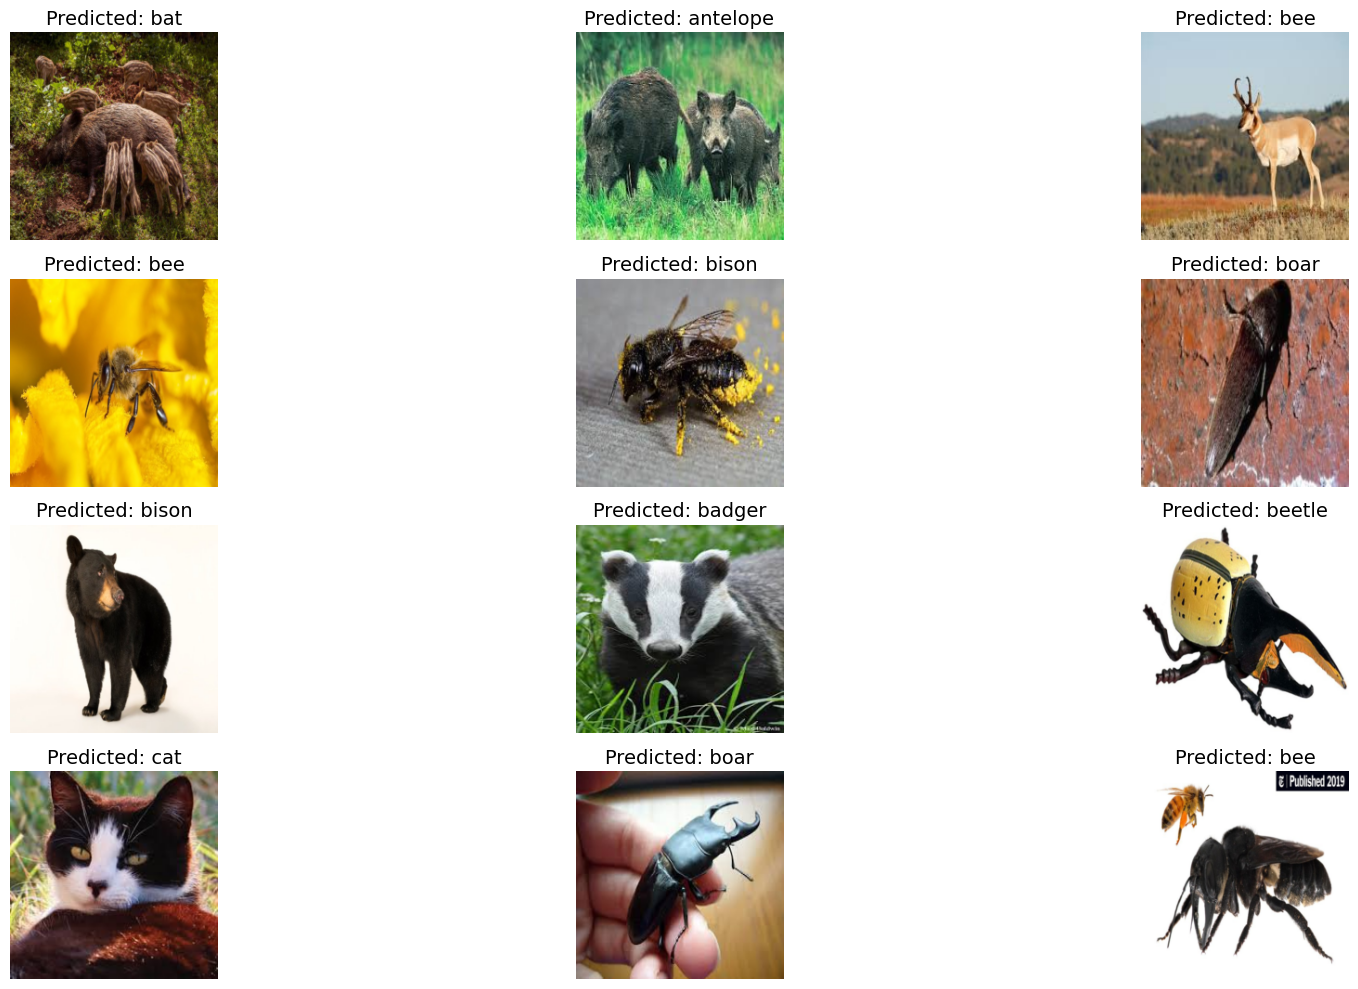

In [36]:
# Sample 12 random indices from the test dataset
sample_indices = random.sample(range(len(test_loader.dataset)), 12)

# Create a grid of 4x3 subplots
fig, axes = plt.subplots(4, 3, figsize=(20, 10))

# Iterate over the sampled indices and plot the corresponding images
for ax, idx in zip(axes.flatten(), sample_indices):
    # Get the image and label from the dataset
    image, _ = test_loader_for_display.dataset[idx]
    
    # Convert tensor to PIL Image for display
    img = transforms.ToPILImage()(image)

    # Display the image on the axis
    ax.imshow(img)
    ax.axis('off')

    # Get the predicted class for this image
    predicted_class = test_classes[idx]

    # Set the title of the subplot to the predicted class
    ax.set_title(f"Predicted: {predicted_class}", fontsize=14)

plt.tight_layout()

In [29]:
targets_test = torch.cat([labels for _, labels in test_loader]).to("cpu")

test_accuracy = accuracy_score(targets_test, test_predictions)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(targets_test, test_predictions, average='weighted')

print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")
print(f"Test F1 Score: {test_f1:.2f}")

Test Accuracy: 0.59
Test Precision: 0.59
Test Recall: 0.59
Test F1 Score: 0.58


## Results Analysis and Future Improvements

### Key Findings
- The simpler architecture (single convolution per block) outperformed the more complex one, likely due to our relatively small dataset size
- Validation accuracy consistently higher than training accuracy indicates the effect of dropout during training
- Increasing validation loss over time suggests some overfitting despite regularization measures

### What Works Well
- Data normalization and augmentation improved model generalization
- The combination of cross-entropy and triplet margin loss provided better feature learning
- Dropout regularization helped prevent complete overfitting

### Challenges Faced
- Feature dimension calculation between convolution and fully connected layers required careful attention
- Finding the right balance of model complexity for our dataset size
- Training stability with the combined loss functions

### Future Improvements
1. **Architecture Enhancements**:
   - Experiment with residual connections (ResNet-style)
   - Try attention mechanisms to focus on important features
   - Implement feature pyramid networks for multi-scale feature learning

2. **Training Strategies**:
   - Implement learning rate scheduling
   - Try different optimizers (SGD with momentum, AdamW)
   - Use more sophisticated data augmentation techniques

3. **Dataset Improvements**:
   - Expand to more classes as model improves
   - Address any class imbalance issues
   - Potentially pre-train on a larger dataset and fine-tune

4. **Evaluation Refinements**:
   - Implement k-fold cross-validation for more robust performance estimates
   - Add additional metrics like precision, recall for each class
   - Visualize feature embeddings using t-SNE or UMAP